In [1]:
!nvidia-smi

Tue Feb 11 09:12:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchvision transformers datasets biopython rdkit seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
!pip install tqdm

In [7]:
import random  #koristimo za prikaz podataka
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [9]:
data = load_dataset("emre570/breastcancer-ultrasound-images")

README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/624 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/156 [00:00<?, ? examples/s]

In [10]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [11]:
labels_dict = {
    0: 'benign',
    1: 'malignant',
    2: 'normal'
}

In [13]:
random_indices=random.sample(range(len(data["train"])), 5)
random_indices

[466, 228, 222, 243, 325]

In [14]:
images = [data['train']['image'][i] for i in random_indices]

In [18]:
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=432x473>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=526x474>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=585x429>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=752x578>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=848x685>]

In [15]:
labels = [data['train']['label'][i] for i in random_indices]

In [17]:
labels

[1, 0, 0, 0, 0]

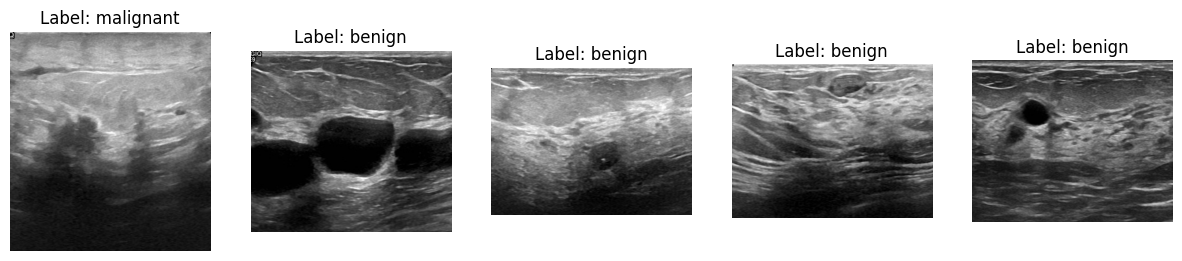

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f'Label: {labels_dict[labels[i]]}')
    ax.axis('off')

plt.show()

In [19]:
torch.cuda.is_available()

True

In [20]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
print(f'Using device: {device}')

Using device: cuda


In [22]:
device

device(type='cuda')

In [24]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])


In [28]:
class CustomDataset(Dataset):
  def __init__(self, hf_dataset, transform=None):
    self.dataset = hf_dataset
    self.transform = transform
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    sample = self.dataset[idx]
    image = sample['image']
    label = sample['label']
    if self.transform:
      image = self.transform(image)
    return image, label

In [29]:
train_dataset = CustomDataset(data['train'], transform=transform)
test_dataset = CustomDataset(data['test'], transform=transform)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
train_loader

In [33]:
class SimpleCNN(nn.Module):  # Defines a custom CNN model by inheriting from nn.Module
    def __init__(self, num_classes):  # Initializes the model and takes the number of output classes as an argument
        super(SimpleCNN, self).__init__()  # Calls the constructor of nn.Module

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Convolutional layer: 3 input channels (RGB), 32 filters, 3x3 kernel
            nn.ReLU(),  # ReLU activation to introduce non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling to reduce feature map size by half

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer: 32 input channels, 64 filters, 3x3 kernel
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling to further reduce feature map size
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 56 * 56, 128),  # Fully connected layer: flattens and maps features to 128 neurons
            nn.ReLU(),  # ReLU activation
            nn.Linear(128, num_classes)  # Output layer: maps 128 neurons to the number of classes
        )

    def forward(self, x):  # Defines the forward pass of the model
        x = self.conv_layers(x)  # Passes input through convolutional layers
        x = x.view(x.size(0), -1)  # Flattens the feature maps to prepare for fully connected layers
        x = self.fc_layers(x)  # Passes through fully connected layers
        return x  # Returns the final output (class scores)

In [37]:
def train_model(num_epochs, train_loader, model, criterion, optimizer, device):

  epoch_losses = []
  for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct, total = 0, 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
      images, labels = batch[0].to(device), batch[1].to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      _, predicted = outputs.max(1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

    epoch_losses.append(running_loss / len(train_loader))
    train_acc = correct / total

    print(f'Epoch {epoch+1}: Loss = {running_loss / len(train_loader)}, Accuracy = {train_acc}')

  plt.plot(range(1, num_epochs + 1), epoch_losses, color='b')
  plt.title('Training Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.show()

In [32]:
num_classes = 3

In [35]:
model = SimpleCNN(num_classes).to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch 1: Loss = 2.4625465005636213, Accuracy = 0.49038461538461536


Epoch 2/10: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Epoch 2: Loss = 0.9445059508085251, Accuracy = 0.5288461538461539


Epoch 3/10: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


Epoch 3: Loss = 0.7114084243774415, Accuracy = 0.7099358974358975


Epoch 4/10: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


Epoch 4: Loss = 0.4153794936835766, Accuracy = 0.8493589743589743


Epoch 5/10: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Epoch 5: Loss = 0.17602717466652393, Accuracy = 0.9535256410256411


Epoch 6/10: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 6: Loss = 0.09073542319238186, Accuracy = 0.9743589743589743


Epoch 7/10: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 7: Loss = 0.04132924196310341, Accuracy = 0.9887820512820513


Epoch 8/10: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 8: Loss = 0.029679723689332603, Accuracy = 0.9919871794871795


Epoch 9/10: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Epoch 9: Loss = 0.03835150862578303, Accuracy = 0.9935897435897436


Epoch 10/10: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

Epoch 10: Loss = 0.0208110103267245, Accuracy = 0.9935897435897436


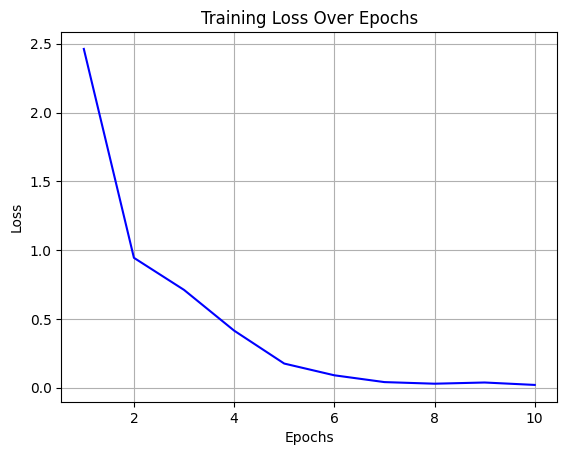

In [38]:
train_model(num_epochs = 10,
            train_loader= train_loader,
            model = model,
            criterion = criterion,
            optimizer = optimizer,
            device = device
            )

In [46]:
def evaluate_model(test_loader, model, device, labels_dict):
  model.eval()
  y_true, y_pred = [], []

  with torch.no_grad():
    for batch in test_loader:
      images, labels = batch[0].to(device), batch[1].to(device)
      outputs = model(images)
      _, predicted = outputs.max(1)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

  test_acc = accuracy_score(y_true, y_pred)
  print(f'Test Accuracy: {test_acc}')

  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=[labels_dict[i] for i in range(len(labels_dict))],
              yticklabels=[labels_dict[i] for i in range(len(labels_dict))])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

Test Accuracy: 0.7564102564102564


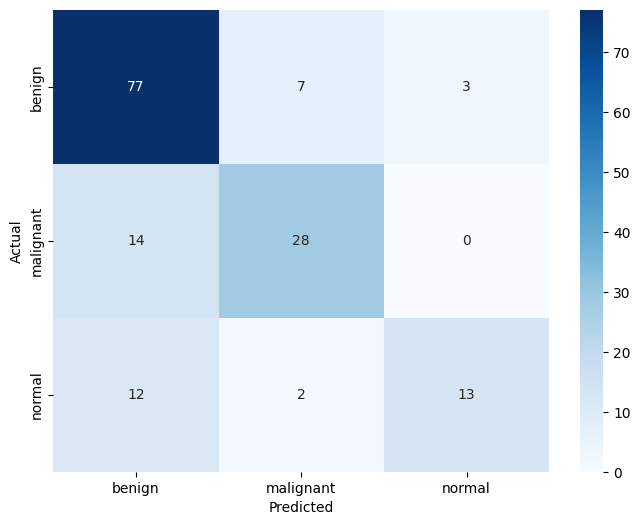

In [47]:
evaluate_model(test_loader=test_loader,
               model=model,
               device=device,
               labels_dict=labels_dict)

In [48]:
class_weights = torch.tensor([0.5, 2, 0.5]).to(device)

In [51]:
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss(class_weights) #adding weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Epoch 1: Loss = 3.834581607580185, Accuracy = 0.41346153846153844


Epoch 2/10: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 2: Loss = 0.8478356599807739, Accuracy = 0.48717948717948717


Epoch 3/10: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 3: Loss = 0.770873349905014, Accuracy = 0.5641025641025641


Epoch 4/10: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Epoch 4: Loss = 0.6529274702072143, Accuracy = 0.6314102564102564


Epoch 5/10: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 5: Loss = 0.49364651590585706, Accuracy = 0.7291666666666666


Epoch 6/10: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Epoch 6: Loss = 0.3151721656322479, Accuracy = 0.8381410256410257


Epoch 7/10: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


Epoch 7: Loss = 0.17122496478259563, Accuracy = 0.9198717948717948


Epoch 8/10: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 8: Loss = 0.08885216461494565, Accuracy = 0.969551282051282


Epoch 9/10: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Epoch 9: Loss = 0.05117771117947996, Accuracy = 0.9839743589743589


Epoch 10/10: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


Epoch 10: Loss = 0.03575770340976305, Accuracy = 0.9903846153846154


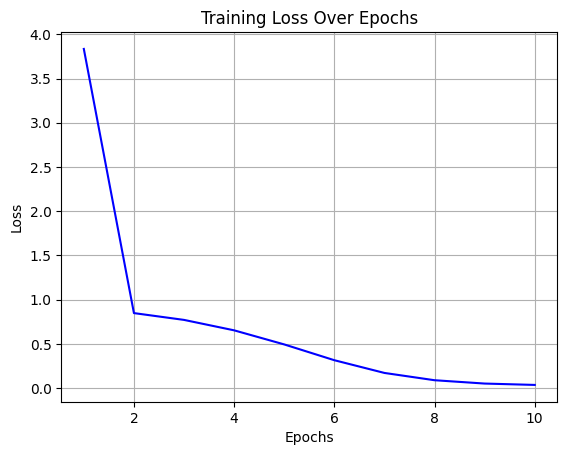

In [52]:
train_model(num_epochs = 10,
            train_loader= train_loader,
            model = model,
            criterion = criterion,
            optimizer = optimizer,
            device = device
            )

Test Accuracy: 0.6282051282051282


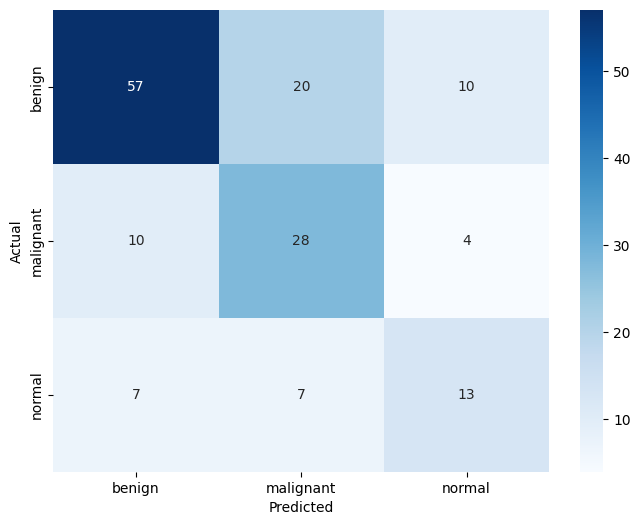

In [53]:
evaluate_model(test_loader=test_loader,
               model=model,
               device=device,
               labels_dict=labels_dict)

## Primjena dubokih neuronskih mreža

In [54]:
# navodno ne moramo pisat, nemamo vremena